In [1]:
# mamba create -n torchvinecopulib python=3.12 -y
# mamba activate torchvinecopulib
# mamba install -c conda-forge uv
# # mamba install -c conda-forge \
# #     "numpy>=2" \
# #     scipy \
# #     coverage \
# #     datasets \
# #     furo \
# #     ipykernel \
# #     kagglehub \
# #     lightgbm \
# #     matplotlib \
# #     pandas \
# #     pot \
# #     pytest \
# #     python-dotenv \
# #     pyvinecopulib \
# #     ruff \
# #     scikit-learn \
# #     sklearn-quantile \
# #     sphinx \
# #     tokenize-rt \
# #     ucimlrepo \
# #     yfinance \
# #     uv

# uv pip install -e ".[cu124]"
# uv pip install lightning torchvision ipykernel seaborn

In [2]:
import os
from dataclasses import dataclass

import pandas as pd
import pytorch_lightning as pl
import pyvinecopulib as pvc
import seaborn as sns
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import torchvinecopulib as tvc

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


@dataclass
class Config:
    data_dir: str = os.environ.get("PATH_DATASETS", ".")
    save_dir: str = "logs/"
    batch_size: int = 512 if torch.cuda.is_available() else 64
    max_epochs: int = 10
    accelerator: str = "auto"
    devices: int = 1


config = Config()

In [3]:
class LitMNISTAutoencoder(pl.LightningModule):
    def __init__(
        self,
        data_dir: str = config.data_dir,
        hidden_size: int = 64,
        learning_rate: float = 2e-4,
        use_vine: bool = False,
        vine_type: str = "tvc",
    ):
        super().__init__()
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.use_vine = use_vine
        self.vine_type = vine_type
        self.vine = nn.Identity()  # Ensures registration

        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        flat_dim = channels * width * height

        # self.transform = transforms.Compose(
        #     [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        # )
        self.transform = transforms.Compose([transforms.ToTensor()])

        # Encoder: flatten → hidden → latent
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 10),
        )

        # Decoder: latent → hidden → image
        self.decoder = nn.Sequential(
            nn.Linear(10, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, flat_dim),
            nn.Sigmoid(),  # Ensure output in [0,1] range
        )

    def set_vine(self, vine):
        if self.vine_type == "tvc":
            if not isinstance(vine, tvc.VineCop):
                raise ValueError("Vine must be of type tvc.VineCop for tvc.")
        elif self.vine_type == "vinecopulib":
            if not isinstance(vine, pvc.Vinecop):
                raise ValueError("Vine must be of type pvc.Vinecop for pvc.")
        else:
            raise ValueError(f"Unknown vine type: {self.vine_type}")
        self.vine = vine

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)
        x_hat = self.decoder(z)
        if not self.use_vine:
            return x_hat.view(-1, *self.dims)
        else:
            # also return the latent representation
            z = z.view(-1, 10)
            return x_hat.view(-1, *self.dims), z

    def training_step(self, batch, batch_idx):
        x, _ = batch
        if self.use_vine:
            x_hat, z = self(x)
            loss = F.mse_loss(x_hat, x) - self.vine.log_pdf(z).mean()
        else:
            x_hat = self(x)
            loss = F.mse_loss(x_hat, x)

        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        if self.use_vine:
            x_hat, z = self(x)
            loss = F.mse_loss(x_hat, x) - self.vine.log_pdf(z).mean()
        else:
            x_hat = self(x)
            loss = F.mse_loss(x_hat, x)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        if self.use_vine:
            x_hat, z = self(x)
            loss = F.mse_loss(x_hat, x) - self.vine.log_pdf(z).mean()
        else:
            x_hat = self(x)
            loss = F.mse_loss(x_hat, x)
        self.log("test_loss", loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=config.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=config.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=config.batch_size)


In [4]:
# Instantiate the LitMNISTAutoencoder
model = LitMNISTAutoencoder()

# Instantiate a checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # metric to monitor
    mode="min",  # "min" for val_loss, "max" for accuracy
    save_top_k=1,  # only save the best model
    save_last=True,  # also save the last epoch
    dirpath=config.save_dir,  # where to save
    filename="{epoch:02d}-{val_loss:.4f}",  # optional: filename format
)

# Instantiate a PyTorch Lightning trainer with the specified configuration
trainer = pl.Trainer(
    accelerator=config.accelerator,
    devices=config.devices,
    max_epochs=config.max_epochs,
    logger=CSVLogger(save_dir=config.save_dir),
    callbacks=[checkpoint_callback],
)

# Train the model using the trainer
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GRID A100D-16C') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.68MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 266kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]
/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/thibault/torchvinecopulib/examples/logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | vine    | Identity   | 0      | train
1 | encoder | Sequential | 52.6 K | train
2 | decoder | Sequential | 53.4 K | train
-----------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 108/108 [00:05<00:00, 21.13it/s, v_num=0, train_loss=0.0588, val_loss=0.0584]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 108/108 [00:05<00:00, 21.08it/s, v_num=0, train_loss=0.0588, val_loss=0.0584]


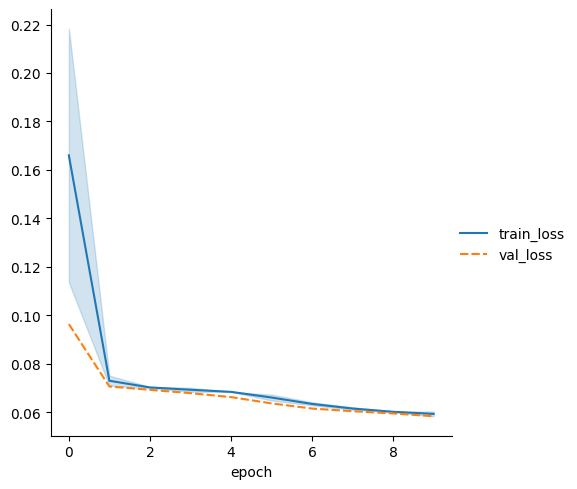

In [5]:
# Read in the training metrics from the CSV file generated by the logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Remove the "step" column, which is not needed for our analysis
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace=True)

# Create a line plot of the training metrics using Seaborn
sns.relplot(data=metrics, kind="line")

In [6]:
# # last_path = os.path.join(config.save_dir, "last.ckpt")  # default naming
# # Load best checkpoint
# inference_model = LitMNISTAutoencoder.load_from_checkpoint(
#     checkpoint_path=checkpoint_callback.best_model_path
# )
# inference_model.eval()
# inference_model.freeze()

# inference_model.prepare_data()
# inference_model.setup(stage="fit")  # sets model.mnist_train, model.mnist_val
# inference_model.to(DEVICE)
#

In [10]:
model.setup(stage="fit")
train_loader = model.train_dataloader()
representations = []
decoded = []
labels = []

for batch in train_loader:
    x, y = batch
    with torch.no_grad():
        z = model.encoder(x)
        x_hat = model.decoder(z)
    decoded.append(x_hat)
    representations.append(z)
    labels.append(y)

# Concatenate into a single tensor
representations = torch.cat(representations, dim=0)
labels = torch.cat(labels, dim=0)

In [11]:
n_samples = 5000
representations_subset = representations[torch.randperm(representations.shape[0])[:n_samples]]
vine_tvc = tvc.VineCop(
    num_dim=representations_subset.shape[1],
    is_cop_scale=False,
    num_step_grid=30,
).to(DEVICE)
vine_tvc.fit(
    obs=representations_subset,
    is_tll=True,
)
# sns.histplot(
#     x=vine_tvc.log_pdf(representations_subset).cpu().numpy().reshape(-1),
#     bins=100,
# )

In [12]:
refit_model = LitMNISTAutoencoder.load_from_checkpoint(
    checkpoint_path=checkpoint_callback.best_model_path
)
refit_model.use_vine = True
refit_model.set_vine(vine_tvc)

# Instantiate a checkpoint callback
refit_checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # metric to monitor
    mode="min",  # "min" for val_loss, "max" for accuracy
    save_top_k=1,  # only save the best model
    save_last=True,  # also save the last epoch
    dirpath=config.save_dir,  # where to save
    filename="{epoch:02d}-{val_loss:.4f}",  # optional: filename format
)

# Instantiate a new trainer with the specified configuration
refit_trainer = pl.Trainer(
    accelerator=config.accelerator,
    devices=config.devices,
    max_epochs=config.max_epochs,
    logger=CSVLogger(save_dir=config.save_dir),
    callbacks=[refit_checkpoint_callback],
)

# Train the model using the trainer
refit_trainer.fit(refit_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/thibault/torchvinecopulib/examples/logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | vine    | VineCop    | 0      | train
1 | encoder | Sequential | 52.6 K | train
2 | decoder | Sequential | 53.4 K | train
-----------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking:   0%|          | 0/2 [00:00<?, ?it/s]

/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/thibault/miniforge3/envs/torchvinecopulib/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 108/108 [00:11<00:00,  9.20it/s, v_num=1, train_loss=2.120, val_loss=2.500]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 108/108 [00:11<00:00,  9.14it/s, v_num=1, train_loss=2.120, val_loss=2.500]


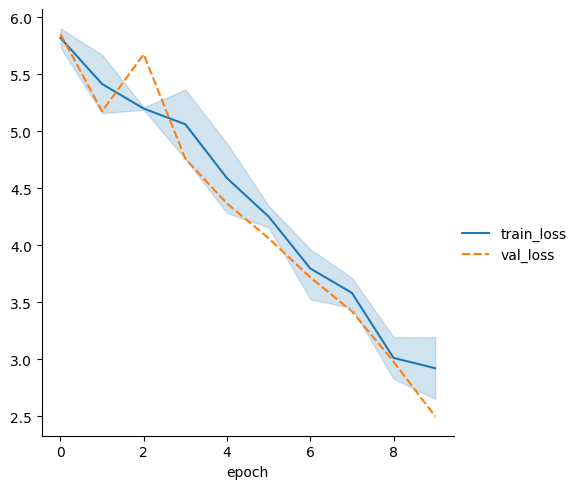

In [13]:
# Read in the training metrics from the CSV file generated by the logger
metrics = pd.read_csv(f"{refit_trainer.logger.log_dir}/metrics.csv")

# Remove the "step" column, which is not needed for our analysis
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace=True)

# Create a line plot of the training metrics using Seaborn
sns.relplot(data=metrics, kind="line")

In [ ]:
# # last_path = os.path.join(config.save_dir, "last.ckpt")  # default naming
# # Load best checkpoint
# # inference_refit_model = LitMNISTAutoencoder.load_from_checkpoint(
# #     checkpoint_path=refit_checkpoint_callback.best_model_path
# # )
# import copy

# inference_refit_model = copy.deepcopy(refit_model)
# inference_refit_model.eval()
# inference_refit_model.freeze()
# inference_refit_model.eval()
# inference_refit_model.freeze()

# inference_refit_model.prepare_data()
# inference_refit_model.setup(stage="fit")  # sets model.mnist_train, model.mnist_val
# train_loader = inference_refit_model.train_dataloader()

In [14]:
model.setup(stage="test")
test_loader = model.test_dataloader()
representations = []
decoded = []
labels = []
data = []
samples = []
for batch in test_loader:
    x, y = batch
    with torch.no_grad():
        z = model.encoder(x)
        x_hat = model.decoder(z)
        sample = vine_tvc.sample(x.shape[0])
        sample = model.decoder(torch.tensor(sample, dtype=z.dtype))
    decoded.append(x_hat)
    representations.append(z)
    labels.append(y)
    data.append(x)
    samples.append(sample)

# Concatenate into a single tensor
representations = torch.cat(representations, dim=0)
labels = torch.cat(labels, dim=0)
data = torch.cat(data, dim=0).flatten(start_dim=1)
decoded = torch.cat(decoded, dim=0)
samples = torch.cat(samples, dim=0)

refit_representations = []
refit_decoded = []
refit_labels = []
refit_data = []
refit_samples = []
for batch in test_loader:
    x, y = batch
    with torch.no_grad():
        z = refit_model.encoder(x)
        x_hat = refit_model.decoder(z)
        sample = vine_tvc.sample(x.shape[0])
        sample = refit_model.decoder(torch.tensor(sample, dtype=z.dtype))
    refit_decoded.append(x_hat)
    refit_representations.append(z)
    refit_labels.append(y)
    refit_data.append(x)
    refit_samples.append(sample)

# Concatenate into a single tensor
refit_representations = torch.cat(refit_representations, dim=0)
refit_labels = torch.cat(refit_labels, dim=0)
refit_data = torch.cat(refit_data, dim=0).flatten(start_dim=1)
refit_decoded = torch.cat(refit_decoded, dim=0)
refit_samples = torch.cat(refit_samples, dim=0)


class GraphModule(torch.nn.Module):
    def forward(self, L_kwargs_fun_closure_0_cell_contents: "f64[512, 1][1, 1]cpu", L_kwargs_fun_closure_2_cell_contents: "f64[512, 1][1, 1]cpu", L_kwargs_x_a_: "f64[512, 1][1, 1]cpu", L_kwargs_fun_closure_1_cell_contents_buffers_dd_: "f64[0][1]cpu", L_kwargs_fun_closure_1_cell_contents_buffers_hfunc_r_grid_: "f64[30, 30][30, 1]cpu", L_kwargs_x_b_: "f64[512, 1][1, 1]cpu"):
        l_kwargs_fun_closure_0_cell_contents = L_kwargs_fun_closure_0_cell_contents
        l_kwargs_fun_closure_2_cell_contents = L_kwargs_fun_closure_2_cell_contents
        l_kwargs_x_a_ = L_kwargs_x_a_
        l_kwargs_fun_closure_1_cell_contents_buffers_dd_ = L_kwargs_fun_closure_1_cell_contents_buffers_dd_
        l_kwargs_fun_closure_1_cell_contents_buffers_hfunc_r_grid_ = L_kwargs_fun_closure_1_cell_contents_buffers_hfunc_r_grid_
        l_kwargs_x_b_ = L_kwargs_x_b_
        
         # File: /home/thibault/torchvinecopulib/torchvinecopulib/bicop/__init__.py:375 in <lambda

In [15]:
print(vine_tvc.log_pdf(representations).mean(), vine_tvc.log_pdf(refit_representations).mean())

tensor(-9.1845, dtype=torch.float64) tensor(-2.6616, dtype=torch.float64)


In [ ]:
import math

import numpy as np
from scipy import linalg


def distance(X, Y, sqrt, device):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX, -1).to(device)
    X2 = (X * X).sum(1).resize_(nX, 1)
    Y = Y.view(nY, -1).to(device)
    Y2 = (Y * Y).sum(1).resize_(nY, 1)

    M = torch.zeros(nX, nY)
    M.copy_(
        X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) - 2 * torch.mm(X, Y.transpose(0, 1))
    )

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    ft = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat((Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float("inf")
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_t = s.tp / (s.tp + s.fn)
    s.acc_f = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k

    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())

    return mmd


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + np.trace(C + C_w - 2 * C_C_w_sqrt)
    return np.sqrt(score)


class Score:
    mmd = 0
    knn = Score_knn()
    fid = 0


def compute_score(real, fake, device, k=1, sigmas=[1e-3, 1e-2, 1e-1, 1, 10, 100], sqrt=True):
    Mxx = distance(real, real, False, device)
    Mxy = distance(real, fake, False, device)
    Myy = distance(fake, fake, False, device)

    s = Score()
    s.mmd = sum(mmd(Mxx, Mxy, Myy, sigma) for sigma in sigmas)
    # s.knn = knn(Mxx, Mxy, Myy, k, sqrt)
    s.fid = fid(real, fake)

    return s


In [ ]:
sigmas = [1e-3, 1e-2, 1e-1, 1, 10, 100]
score_model = compute_score(data, samples, DEVICE, sigmas=sigmas)
score_refit_model = compute_score(refit_data, refit_samples, DEVICE, sigmas=sigmas)
print("Model scores (original vs refit):")
print(
    f"MMD: {score_model.mmd} vs {score_refit_model.mmd} => original is {score_model.mmd / score_refit_model.mmd} x worse"
)
print(
    f"FID: {score_model.fid} vs {score_refit_model.fid} => original is {score_model.fid / score_refit_model.fid} x worse"
)

/tmp/ipykernel_59813/887449587.py:109: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.sqrt(score)


Model scores (original vs refit):
MMD: 0.6405504881355075 vs 0.50656937613023 => original is 1.2644871923146679× worse
FID: 6.64518928527832 vs 6.423532009124756 => original is 1.0345070362091064× worse
